In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report
from tqdm import tqdm
from skimage import color

import shutil
from torchvision.models import Inception_V3_Weights

seed = 42
random.seed(seed)

# Improvement Model B
Previously, our baseline model relied solely on Lab channels, but we observed that leaf images often had brown or blue backgrounds that Lab alone struggled to capture. To remedy this, we fused the RGB channels with Lab, creating a six‑channel input that preserves both color and luminance information. We then swapped out the randomly initialized InceptionV3 for a pretrained EfficientNet backbone, leveraging its strong ImageNet features. This dual‑color‑space approach and transfer‑learning boost significantly enhanced our model’s color extraction and overall classification performance.

This is the same model as A except for augmentation. Since our original set contained only about 600–700 leaf images, we were recommended to use data augmentation to enrich it. 

By applying random resized crops, horizontal flips, small rotations, and color jitter to each image—generating roughly five distinct variants per file—we expanded the effective training set to around 3,000–4,000 unique samples, which in turn improved the model’s generalization and accuracy.


#### **What the LabTwoBranchDataset class does**:-

- Dual-Space Conversion: It processes each image in both RGB and Lab color spaces.

- RGB Transformation: It applies optional preprocessing transformations (like resizing or normalization) to the RGB image.

- Lab Conversion & Normalization:

    - Converts the RGB image to the Lab color space.

    - Normalizes the L channel to a range of [0, 1] and the AB channels to [-1, 1] for balanced input distribution.

- Lab Transformation: Allows optional transformations on the Lab image as well.

- Concatenation: Combines the processed RGB and Lab images into a single 6-channel image (3 RGB + 3 Lab).

- Label Mapping: Converts class labels into numeric format for classification tasks.


In [2]:
class RGBLABConcatDataset(Dataset):
    def __init__(self, dataframe, transform_rgb=None, transform_lab=None):
        self.data = dataframe
        self.transform_rgb = transform_rgb
        self.transform_lab = transform_lab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['filepath']
        label = torch.tensor(row['label'], dtype=torch.long)

        img = Image.open(img_path).convert("RGB")

        if self.transform_rgb:
            img_rgb = self.transform_rgb(img)
        else:
            img_rgb = transforms.ToTensor()(img)

        lab = color.rgb2lab(np.array(img)).astype('float32')
        L = lab[:, :, 0] / 100.0                      
        ab = (lab[:, :, 1:] + 128) / 255.0 * 2 - 1   

        L = torch.from_numpy(L).unsqueeze(0)
        ab = torch.from_numpy(ab).permute(2, 0, 1)  

        if self.transform_lab:
            lab_img = torch.cat([L, ab], dim=0)
            lab_img = self.transform_lab(lab_img)
        else:
            lab_img = torch.cat([L, ab], dim=0)

        fused = torch.cat([img_rgb, lab_img], dim=0)

        return fused, label, img_path

### **Model Overview: EfficientNetRGBLAB**
This model is designed to process rich image information from both the RGB and Lab color spaces using a single unified pipeline.

Input: A 6-channel image formed by concatenating:
- 3 channels from the RGB image.
- 3 channels from the Lab-converted image (L, A, B).


**Modified EfficientNet:**

- First Layer Adaptation: The original first convolutional layer of EfficientNet is modified to accept 6-channel input instead of the default 3 channels.

- Feature Extraction: The rest of the EfficientNet architecture is used as-is to extract high-level features from the fused input.

- Classifier Replacement: The final classification layer is replaced to match the number of target classes.

Output: The model outputs a class prediction based on the combined features from both RGB and Lab inputs.

In [14]:
from torchvision.models import efficientnet_b0

class EfficientNetRGBLAB(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = efficientnet_b0(weights='IMAGENET1K_V1')

        self.backbone.features[0][0] = nn.Conv2d(6, 32, kernel_size=3, stride=2, padding=1, bias=False)

        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)


# PlantDoc Dataset

Then we trained and tested the model on the PlantDoc dataset, as was done in the paper.

[PlantDoc](https://github.com/pratikkayal/PlantDoc-Dataset)

In [4]:
# !rmdir --help
!rm -rf /kaggle/working/PlantDoc-Dataset
!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git

Cloning into 'PlantDoc-Dataset'...
remote: Enumerating objects: 2670, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 2670 (delta 22), reused 22 (delta 22), pack-reused 2635 (from 1)
Receiving objects: 100% (2670/2670), 932.92 MiB | 48.75 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (2581/2581), done.


### Loading the dataset
We loaded the dataset and displayed class counts and some sample images

In [5]:
dataset_path = '/kaggle/working/PlantDoc-Dataset/'

def load_image_paths_and_labels(dataset_path):
    image_paths = []
    labels = []
    label_dict = {}  
    label_idx = 0
    class_counts = {}  
    class_samples = {}  
    
    for root, dirs, files in os.walk(dataset_path):
        if 'train' in root or 'test' in root:
            for folder in dirs:
                if folder.startswith('Tomato'):  # Only include folders starting with 'Tomato'
                    for file in os.listdir(os.path.join(root, folder)):
                        if file.endswith(('.jpg', '.png')):
                            image_path = os.path.join(root, folder, file)
                            label = folder
                            if label not in label_dict:
                                label_dict[label] = label_idx
                                label_idx += 1
                            image_paths.append(image_path)
                            labels.append(label_dict[label])
                            
                            if label not in class_counts:
                                class_counts[label] = 0
                            class_counts[label] += 1

                            if label not in class_samples:
                                class_samples[label] = []
                            if len(class_samples[label]) < 3:
                                class_samples[label].append(image_path)
    
    return pd.DataFrame({'filepath': image_paths, 'label': labels}), label_dict, class_counts, class_samples

In [6]:
train_df, label_dict, train_class_counts, train_class_samples = load_image_paths_and_labels(os.path.join(dataset_path, 'train'))
test_df, _, test_class_counts, test_class_samples = load_image_paths_and_labels(os.path.join(dataset_path, 'test'))

In [7]:
print("Number of images per class in the training set:")
for label, count in train_class_counts.items():
    print(f"{label}: {count} images")

print("\nNumber of images per class in the testing set:")
for label, count in test_class_counts.items():
    print(f"{label}: {count} images")

Number of images per class in the training set:
Tomato leaf: 55 images
Tomato leaf yellow virus: 70 images
Tomato Early blight leaf: 79 images
Tomato leaf mosaic virus: 44 images
Tomato leaf late blight: 101 images
Tomato mold leaf: 85 images
Tomato leaf bacterial spot: 101 images
Tomato two spotted spider mites leaf: 2 images
Tomato Septoria leaf spot: 140 images

Number of images per class in the testing set:
Tomato leaf: 8 images
Tomato leaf yellow virus: 6 images
Tomato Early blight leaf: 9 images
Tomato leaf mosaic virus: 10 images
Tomato leaf late blight: 10 images
Tomato mold leaf: 6 images
Tomato leaf bacterial spot: 9 images
Tomato Septoria leaf spot: 11 images


### Sample Images


Sample images from class: Tomato leaf


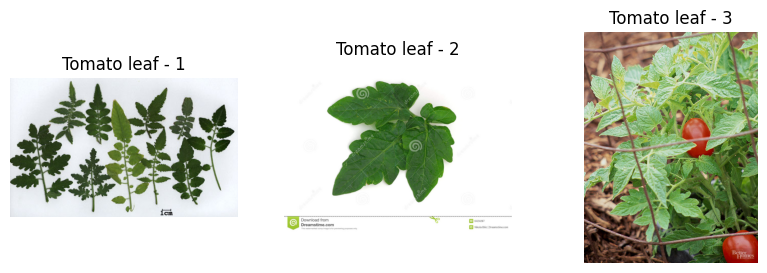


Sample images from class: Tomato leaf yellow virus


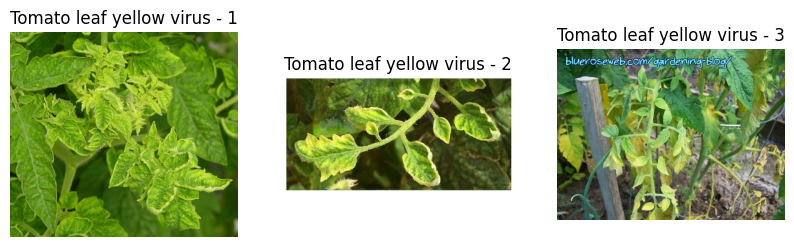


Sample images from class: Tomato Early blight leaf


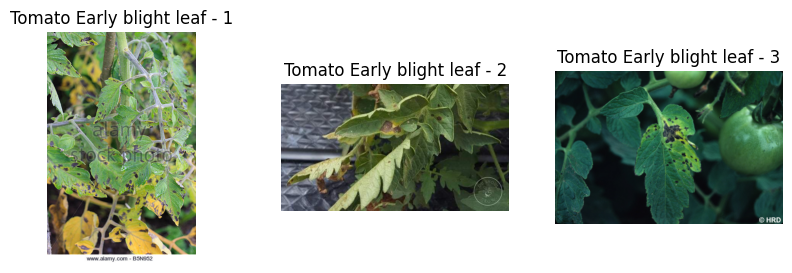


Sample images from class: Tomato leaf mosaic virus


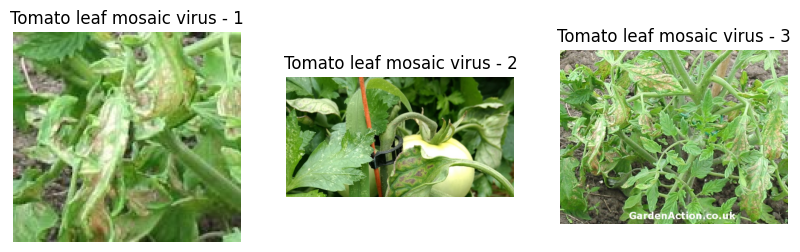


Sample images from class: Tomato leaf late blight


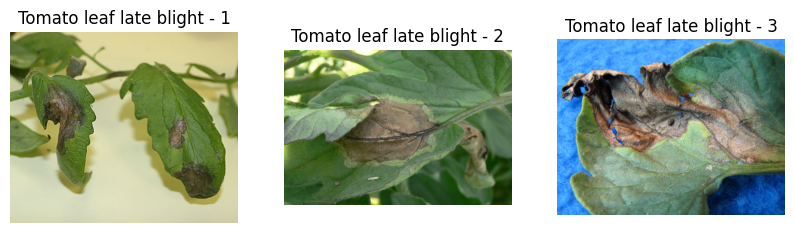


Sample images from class: Tomato mold leaf


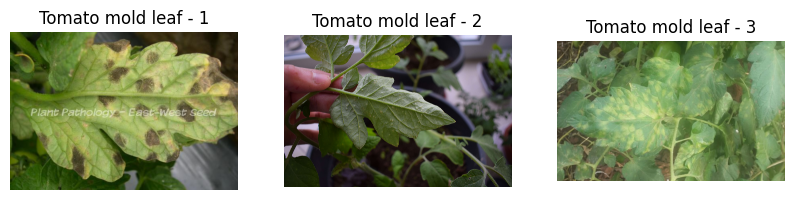


Sample images from class: Tomato leaf bacterial spot


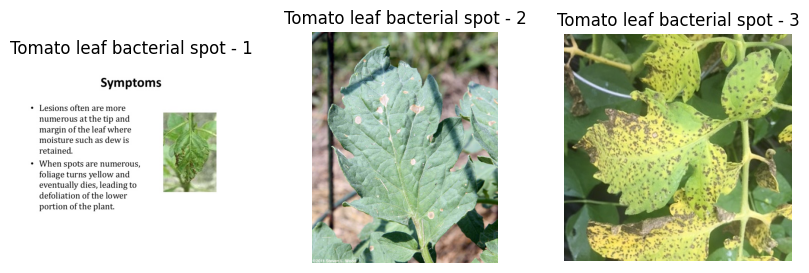


Sample images from class: Tomato two spotted spider mites leaf


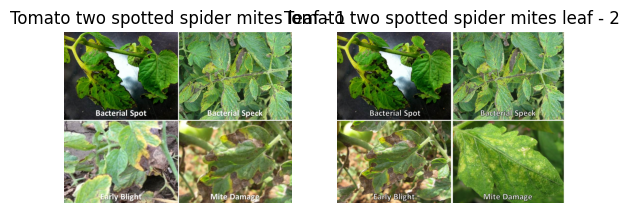


Sample images from class: Tomato Septoria leaf spot


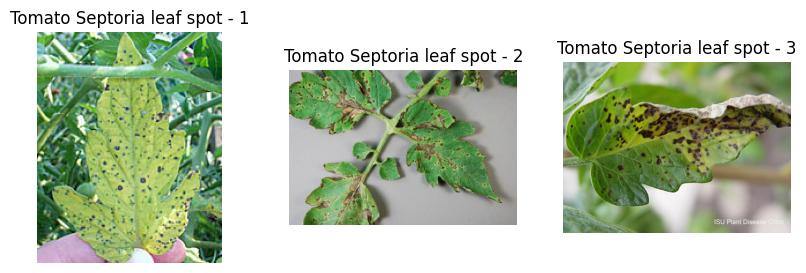


Sample images from class: Tomato leaf


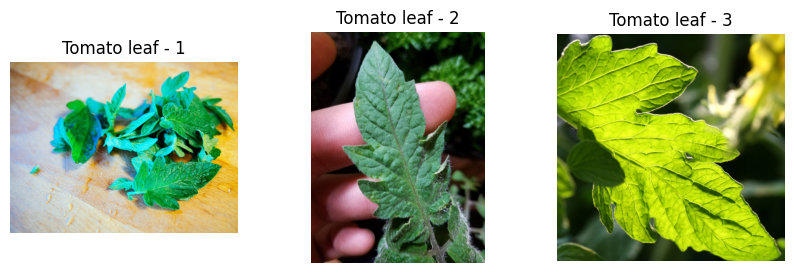


Sample images from class: Tomato leaf yellow virus


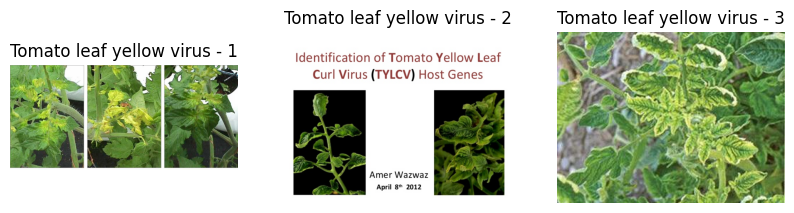


Sample images from class: Tomato Early blight leaf


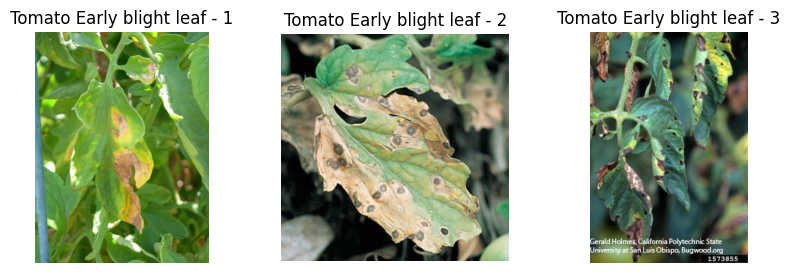


Sample images from class: Tomato leaf mosaic virus


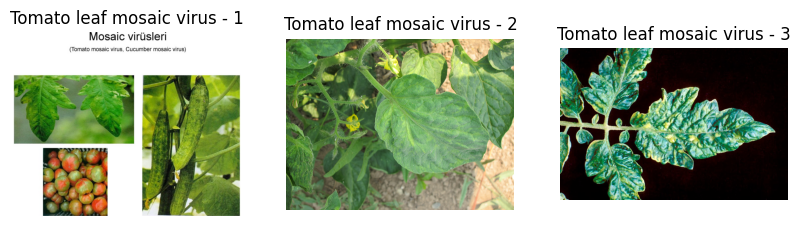


Sample images from class: Tomato leaf late blight


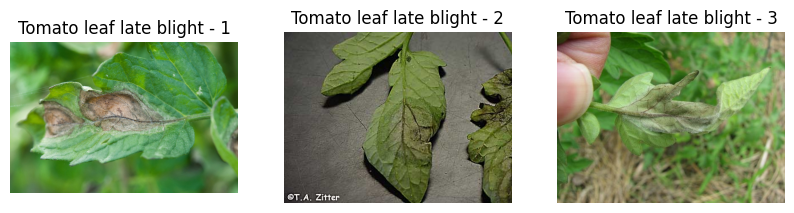


Sample images from class: Tomato mold leaf


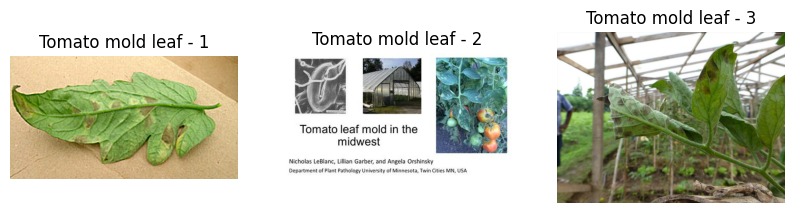


Sample images from class: Tomato leaf bacterial spot


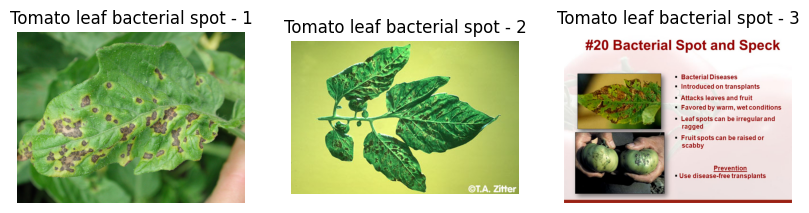


Sample images from class: Tomato Septoria leaf spot


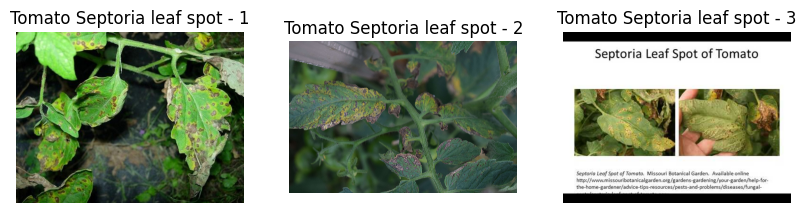

In [8]:
def show_sample_images(class_samples):
    for label, samples in class_samples.items():
        print(f"\nSample images from class: {label}")
        plt.figure(figsize=(10, 3))
        for i, img_path in enumerate(samples):
            img = Image.open(img_path)
            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{label} - {i+1}")
        plt.show()

show_sample_images(train_class_samples)
show_sample_images(test_class_samples)

## Train-Test Split
The original test set provided in PlantDoc was too small. </br>
So we merged both the train and test sets together, and created a new 80-20 split for our use. </br>
We also removed a class *two spotted spider mites leaf* as it had only 2 samples, much less than the other classes

In [9]:
dataset_path = 'PlantDoc-Dataset/'

def merge_train_test_folders(dataset_path, exclude_class="Tomato two spotted spider mites leaf"):
    merged_dataset_path = os.path.join(dataset_path, 'merged')
    if not os.path.exists(merged_dataset_path):
        os.makedirs(merged_dataset_path)
    
    for folder in os.listdir(os.path.join(dataset_path, 'train')):
        if folder.startswith('Tomato') and folder != exclude_class:  
            class_folder = os.path.join(merged_dataset_path, folder)
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)
            
            train_class_folder = os.path.join(dataset_path, 'train', folder)
            for file in os.listdir(train_class_folder):
                if file.endswith(('.jpg', '.png')):
                    shutil.move(os.path.join(train_class_folder, file), os.path.join(class_folder, file))

            test_class_folder = os.path.join(dataset_path, 'test', folder)
            for file in os.listdir(test_class_folder):
                if file.endswith(('.jpg', '.png')):
                    shutil.move(os.path.join(test_class_folder, file), os.path.join(class_folder, file))
    
    print("Data merged successfully into the 'merged' folder, excluding the unwanted class.")

merge_train_test_folders(dataset_path)

Data merged successfully into the 'merged' folder, excluding the unwanted class.


In [10]:
def create_train_test_split(merged_dataset_path, exclude_class="Tomato two spotted spider mites leaf", split_ratio=0.8):
    train_image_paths = []
    train_labels = []
    test_image_paths = []
    test_labels = []
    label_dict = {}
    label_idx = 0
    
    for folder in os.listdir(merged_dataset_path):
        if folder.startswith('Tomato') and folder != exclude_class:  
            class_folder = os.path.join(merged_dataset_path, folder)
            images = [os.path.join(class_folder, file) for file in os.listdir(class_folder) if file.endswith(('.jpg', '.png'))]
            
            train_images, test_images = train_test_split(images, train_size=split_ratio, random_state=seed)

            if folder not in label_dict:
                label_dict[folder] = label_idx
                label_idx += 1
            
            for img in train_images:
                train_image_paths.append(img)
                train_labels.append(label_dict[folder])
            for img in test_images:
                test_image_paths.append(img)
                test_labels.append(label_dict[folder])
    
    train_df = pd.DataFrame({'filepath': train_image_paths, 'label': train_labels})
    test_df = pd.DataFrame({'filepath': test_image_paths, 'label': test_labels})
    return train_df, test_df, label_dict


##### Our new train-test split

In [11]:
merged_dataset_path = os.path.join(dataset_path, 'merged')
train_df, test_df, label_dict = create_train_test_split(merged_dataset_path)


print("Number of images per class after merge and split (Train):")
class_counts = train_df['label'].value_counts()
for label, count in class_counts.items():
    class_name = list(label_dict.keys())[list(label_dict.values()).index(label)]
    print(f"{class_name}: {count} images")

print("\n")
print("Number of images per class after merge and split (Test):")
class_counts = test_df['label'].value_counts()
for label, count in class_counts.items():
    class_name = list(label_dict.keys())[list(label_dict.values()).index(label)]
    print(f"{class_name}: {count} images")


Number of images per class after merge and split (Train):
Tomato Septoria leaf spot: 120 images
Tomato leaf late blight: 88 images
Tomato leaf bacterial spot: 88 images
Tomato mold leaf: 72 images
Tomato Early blight leaf: 70 images
Tomato leaf yellow virus: 60 images
Tomato leaf: 50 images
Tomato leaf mosaic virus: 43 images


Number of images per class after merge and split (Test):
Tomato Septoria leaf spot: 30 images
Tomato leaf late blight: 23 images
Tomato leaf bacterial spot: 22 images
Tomato mold leaf: 19 images
Tomato Early blight leaf: 18 images
Tomato leaf yellow virus: 15 images
Tomato leaf: 13 images
Tomato leaf mosaic virus: 11 images


### Preprocessing & Model Declaration

Each training image is passed through random augmentations defined in transform_rgb_aug. </br>

These include: random resized cropping, horizontal flipping, rotation, color jitter, perspective distortion, slight translation, and Gaussian blur </br>
All are applied on-the-fly during training to increase variability and help the model generalize better.

In [12]:

IMG_SIZE = 224

transform_rgb_aug = transforms.Compose([
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
])


transform_lab = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
])

transform_rgb_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [15]:
train_dataset = RGBLABConcatDataset(train_df, transform_rgb=transform_rgb_aug, transform_lab=transform_lab)
test_dataset  = RGBLABConcatDataset(test_df, transform_rgb=transform_rgb_test, transform_lab=transform_lab)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = EfficientNetRGBLAB(num_classes=len(label_dict)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]


## Training Loop

In [16]:

train_losses = []
train_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for fused, labels, _ in tqdm(train_loader):
        fused, labels = fused.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(fused)  # Only one input (fused image)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")


100%|██████████| 19/19 [01:24<00:00,  4.46s/it]


Epoch 1 - Loss: 1.8693 - Accuracy: 0.2876


100%|██████████| 19/19 [01:13<00:00,  3.88s/it]


Epoch 2 - Loss: 1.5995 - Accuracy: 0.4247


100%|██████████| 19/19 [01:14<00:00,  3.93s/it]


Epoch 3 - Loss: 1.3552 - Accuracy: 0.5042


100%|██████████| 19/19 [01:06<00:00,  3.49s/it]


Epoch 4 - Loss: 1.1309 - Accuracy: 0.5668


100%|██████████| 19/19 [01:08<00:00,  3.62s/it]


Epoch 5 - Loss: 0.9900 - Accuracy: 0.6599


100%|██████████| 19/19 [01:06<00:00,  3.52s/it]


Epoch 6 - Loss: 0.8647 - Accuracy: 0.7140


100%|██████████| 19/19 [01:13<00:00,  3.87s/it]


Epoch 7 - Loss: 0.6366 - Accuracy: 0.7834


100%|██████████| 19/19 [01:08<00:00,  3.62s/it]


Epoch 8 - Loss: 0.5220 - Accuracy: 0.8139


100%|██████████| 19/19 [01:06<00:00,  3.50s/it]


Epoch 9 - Loss: 0.4523 - Accuracy: 0.8426


100%|██████████| 19/19 [01:09<00:00,  3.63s/it]

Epoch 10 - Loss: 0.3921 - Accuracy: 0.8748


### Training Loss and Accuracy

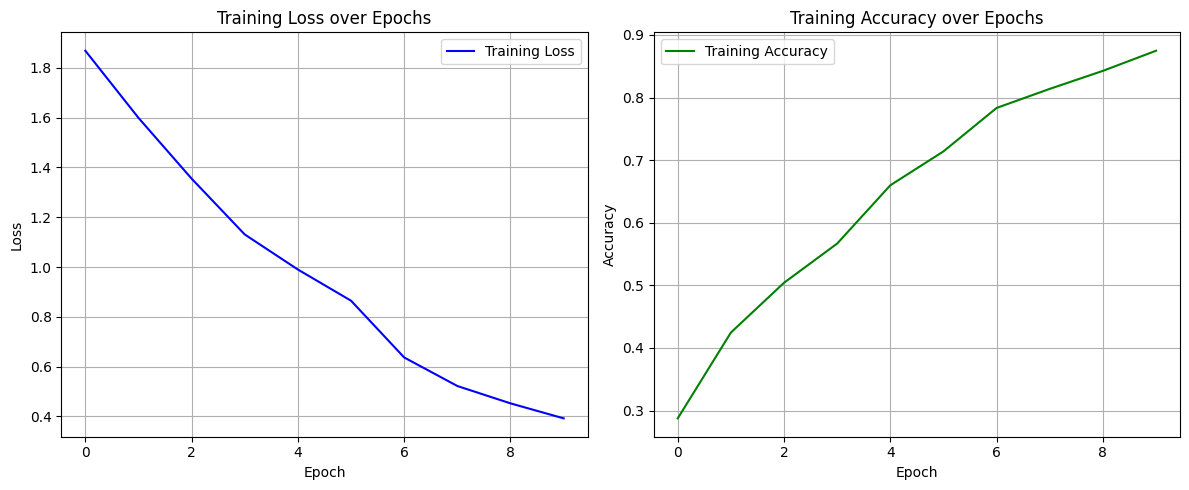

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Evaluation Results

In [18]:
model.eval()
all_preds, all_labels = [], []
misclassified = []

with torch.no_grad():
    for fused, labels, paths in tqdm(test_loader): 
        fused, labels = fused.to(device), labels.to(device)
        outputs = model(fused)
        _, preds = torch.max(outputs, 1)

        preds_np = preds.cpu().numpy()
        labels_np = labels.cpu().numpy()

        all_preds.extend(preds_np)
        all_labels.extend(labels_np)

        for i in range(len(preds_np)):
            if preds_np[i] != labels_np[i]:
                misclassified.append((paths[i], preds_np[i], labels_np[i]))


accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"\nAccuracy on the test set: {accuracy * 100:.2f}%")

print("\nClassification Report on Test Set:")
print(classification_report(all_labels, all_preds, target_names=list(label_dict.keys())))
print("✅ Testing complete.")


100%|██████████| 5/5 [00:24<00:00,  4.98s/it]


Accuracy on the test set: 53.64%

Classification Report on Test Set:
                            precision    recall  f1-score   support

               Tomato leaf       0.67      0.62      0.64        13
  Tomato leaf yellow virus       0.62      0.67      0.65        15
  Tomato Early blight leaf       0.41      0.39      0.40        18
  Tomato leaf mosaic virus       0.47      0.64      0.54        11
   Tomato leaf late blight       0.64      0.70      0.67        23
          Tomato mold leaf       0.41      0.63      0.50        19
Tomato leaf bacterial spot       0.40      0.09      0.15        22
 Tomato Septoria leaf spot       0.59      0.63      0.61        30

                  accuracy                           0.54       151
                 macro avg       0.53      0.54      0.52       151
              weighted avg       0.53      0.54      0.51       151

✅ Testing complete.


**Displaying misclassified images for future reference**

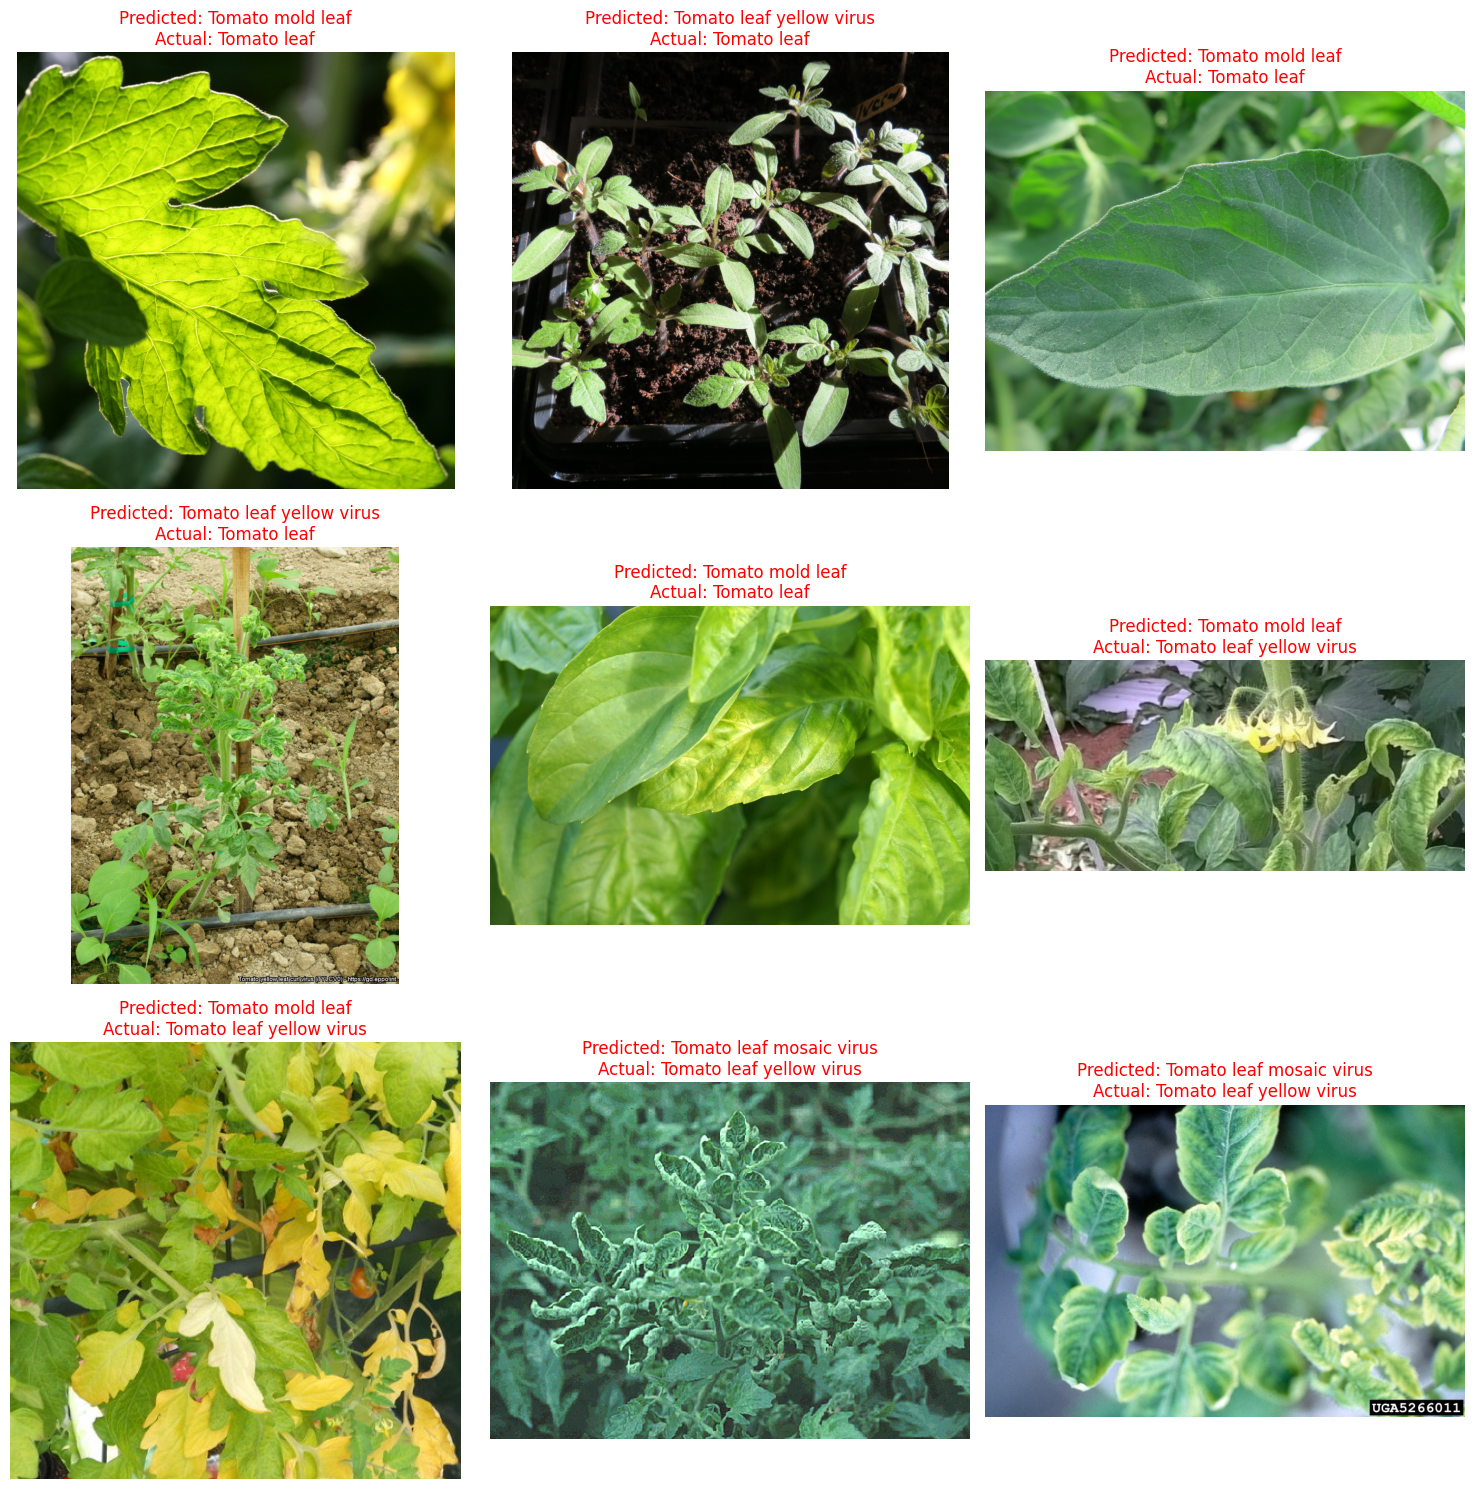

In [19]:
num_to_show = min(9, len(misclassified))
plt.figure(figsize=(15, 15))

for idx in range(num_to_show):
    path, pred_idx, true_idx = misclassified[idx]
    img = Image.open(path).convert("RGB")

    plt.subplot(int(num_to_show/3), 3, idx + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {list(label_dict.keys())[pred_idx]}\nActual: {list(label_dict.keys())[true_idx]}", color="red")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Test Accuracy: 53.64%

In [20]:
torch.save(model.state_dict(), "Improvement1_with_Augments.pth")